# Evolution of actors careers post-blockbuster in the film industry
How does a significant box office success impact an actor's subsequent choices and overall career path ?

##  Context

Analyze career trajectories of actors following their roles in high-grossing films using the CMU Movie Dataset

More specifically, explore the following research questions: 
- Does a high-grossing film consistently lead to **continued box office success** for its actors in their subsequent films?
- Is there a noticeable **change in genre or type of characters** portrayed by actors after a significant hit?
- What are the long-term career impacts on actors who have starred in blockbuster hits?

In [2]:
# External imports
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

## 1. What is a big hit? :
We now have to define what makes a movie a big hit? We will focus on revenue as mentioned eariler but now that we have the IMDb ratings we can also use this information to define a big hit (i.e. a very successful movie). We will consider the product of the movie revenue with its average IMDb rating as a metric for success.

Let's look at the evolution of this metric along the years.

In [3]:
%store -r character_movies_filtered_imdb
%store -r nb_tot_filtered_actors


In [4]:
# Make deep copy of our prepared dataset
df_prepared = character_movies_filtered_imdb.copy()

In [5]:
# Add a column to our dataset for this new success metric
df_prepared['success'] = df_prepared.revenue * df_prepared.averageRating

[]

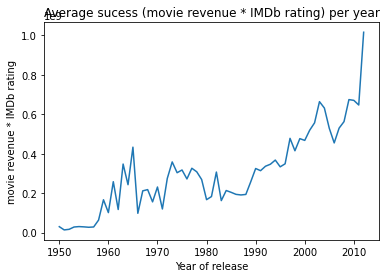

In [6]:
# Get the mean and standard deviation of the success metric for each year
unique_movies = df_prepared.drop_duplicates(subset = 'movieID')

success_per_year = unique_movies.groupby(by = 'year')['success']

avg_success_per_year = success_per_year.mean()
std_success_per_year = success_per_year.std()

# Plot the results
plt.plot(avg_success_per_year)
#plt.fill_between(avg_revenue_per_year.index, (avg_revenue_per_year+std_revenue_per_year).values,
#                 (avg_revenue_per_year-std_revenue_per_year).values, color='lightblue')
plt.title('Average sucess (movie revenue * IMDb rating) per year')
plt.ylabel('movie revenue * IMDb rating')
plt.xlabel('Year of release')
plt.plot()

From this graph we can see a certain fluctuation in the average movie revenue per year.

To keep things simple we will assume that for a movie to be a big hit it has to be an outliner with respect to our previously defined success metric. We will pick only the outliners of each year and label them as big hits. We define an outliner as: outlier's success metric > Q3 + 1.5*(IQR) where Q1, Q3 and IQR are respectively the first quantile, the third quantile and the interquantile range.

The number of big hits is: 659


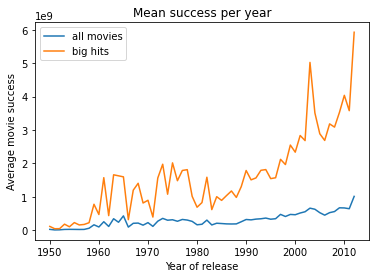

In [7]:
# Compute the first and the third quantile for each year
Q1 = success_per_year.quantile(q=0.25)
Q3 = success_per_year.quantile(q=0.75)

# Compute our ouliner threshold value for each year
outliner_thresh = Q3 + 1.5 *(Q3-Q1)
outliner_thresh.name = 'threshold'

# Filter movie dataset to keep only the big hits
movies_merged = pd.merge(df_prepared, outliner_thresh, left_on='year', right_index=True)
big_hits = movies_merged[movies_merged['success'] > movies_merged['threshold']]

# Plot the mean revenue for big hits compaired to the mean revenue for all movies per year
unique_movie_hits = big_hits.drop_duplicates(subset = 'movieID')
success_hits_per_year = unique_movie_hits.groupby(by = 'year')['success'].mean()

plt.plot(avg_success_per_year, label = 'all movies')
plt.plot(success_hits_per_year, label = 'big hits')

# Add labels
plt.title('Mean success per year')
plt.ylabel('Average movie success')
plt.xlabel('Year of release')
plt.legend()
plt.plot()

# How many big hits do we have?
print(f'The number of big hits is: {len(unique_movie_hits)}')

Do we have enough data? If not: change the ouliner definition or change big hit definition

Now let's divide our actors dataset into the ones that have played in one of those big hits (treatement group) and the ones that did not (control)

In [8]:
# Get a set with the names of the actors that played in a big hit
unique_actor_hits = big_hits.drop_duplicates(subset = 'name_actor').name_actor

# Creat a new column on our main dataframe, a bool for wheter the actors played in a big hit or not
df_prepared['big_hit_actor'] = df_prepared.name_actor.isin(unique_actor_hits)

# Get a dataframe of actors that played in a big hit (treatement group)
actors_big_hit = df_prepared[df_prepared.big_hit_actor]
# Get a dataframe of actors that did not play in a big hit (control group)
actors_no_big_hit = df_prepared[~df_prepared.big_hit_actor]

# Print the number of actors in each group
nb_big_hit_actors = len(unique_actor_hits)

print(f'The number of actors that played in a big hit is: {nb_big_hit_actors} (treatement group)')
print(f'The number of actors that did not play in a big hit is: {nb_tot_filtered_actors-nb_big_hit_actors} (control group)')

The number of actors that played in a big hit is: 4403 (treatement group)
The number of actors that did not play in a big hit is: 5605 (control group)


Now that we have our two groups let's look at the distribution of different variables for which we have information.

We can first look at gender.

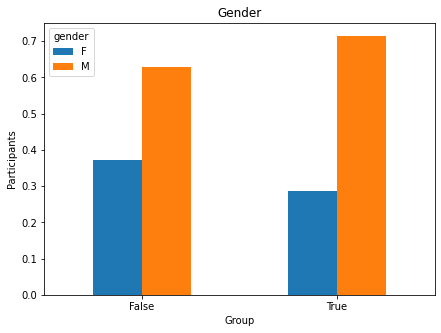

In [9]:
# Gender
group = df_prepared.groupby(['big_hit_actor', 'gender'])['gender'].count()
group = group.unstack()
group = group.div(group.sum(axis=1), axis=0)

pl = group.plot(kind='bar', figsize=[7,5], rot=0)
pl.set_title('Gender')
pl.set_ylabel('Participants')
pl.set_xlabel('Group')
plt.show()

Now let's have look at the repartition of the age at the peak of the acotrs carrier. We define the peak of one actor's carrier by the year where the product of the number of movies played in with their respective success metric is the highest.

In [10]:
from helpers import complete_date
df_prepared['birth'] = df_prepared['birth'].apply(complete_date)
df_prepared['birth'] = pd.to_datetime(df_prepared['birth'], format='%Y-%m-%d')

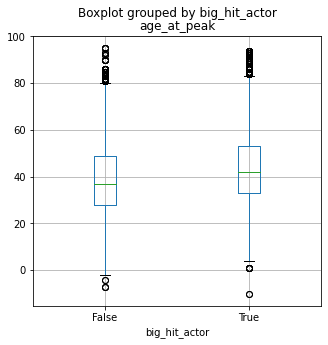

In [11]:
# Calculate the product of the number of movies and respective success metric for each actor and year
df_prepared['product'] = df_prepared.groupby(['name_actor', 'year']).movieID.transform('count') * df_prepared.success

# Find the row with the maximum product for each actor
max_product_rows = df_prepared.loc[df_prepared.groupby('name_actor')['product'].idxmax()]

# Extract the actor and the corresponding year for the maximum product
result = max_product_rows.loc[:, ['name_actor', 'year', 'birth']]

# Create a column in the dataframe with the age of the actors at their carrier peak:
result['age_at_peak'] = result['year'] - result['birth'].dt.year
result['year_of_peak'] = result['year']
df_prepared = pd.merge(df_prepared, result[['name_actor', 'age_at_peak', 'year_of_peak']], on='name_actor', how='left')


# Remove the product column
df_prepared = df_prepared.drop(columns = 'product')

# Visualize distribution

df_prepared.boxplot(by='big_hit_actor', column='age_at_peak', figsize = [5, 5], grid=True)
plt.show()

Now we should look at the distribution of the year of carrer peak for both groups. Maybe we sould also match on this because maybe there is an evolution of trends along the years in the movie industry?

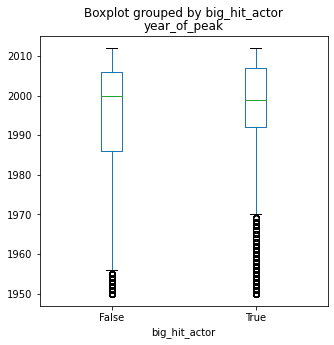

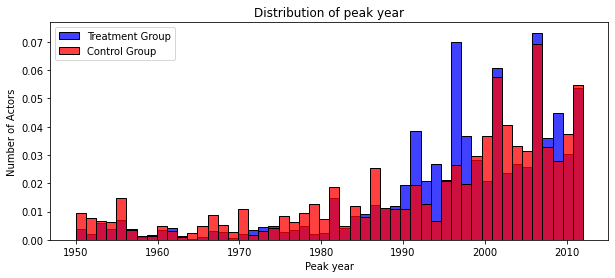

In [12]:
df_prepared.boxplot(by='big_hit_actor', column='year_of_peak', figsize = [5, 5], grid=False)
plt.show()


treatement = df_prepared[df_prepared.big_hit_actor]
control = df_prepared[~df_prepared.big_hit_actor]

# Plot histograms
plt.figure(figsize=(10, 4))
sns.histplot(treatement.year_of_peak, color="blue", label='Treatment Group', bins=50, stat = 'density')
sns.histplot(control.year_of_peak, color="red",  label='Control Group', bins=50, stat = 'density')

plt.title('Distribution of peak year')
plt.xlabel('Peak year')
plt.ylabel('Number of Actors')
plt.legend()
plt.show()

The two groups are actually pretty much balanced on the two variables we looked at. We should probably still perform a matching on these two variables

## 2. Matching

In [13]:
df_prepared['is_big_hit'] = df_prepared.movieID.isin(unique_movie_hits.movieID)
big_hit_actors_df = df_prepared[df_prepared['big_hit_actor'] & df_prepared['is_big_hit']]

# Find the year of the first big hit for each actor
first_big_hit_year = big_hit_actors_df.groupby('name_actor')['year'].min().reset_index()

# Merge the information back into the original DataFrame
df_prepared = pd.merge(df_prepared, first_big_hit_year, on='name_actor', how='left', suffixes=('', '_first_big_hit'))


In [14]:
# Count the number of unique movies each actor has played in
movies_per_actor = df_prepared.groupby('name_actor')['movieID'].nunique()

# Convert the Series to a DataFrame and reset the index
movies_per_actor_df = movies_per_actor.reset_index()
movies_per_actor_df.columns = ['name_actor', 'movie_count']

# Merge with the main DataFrame to associate the movie count with the big_hit_actor bool
df_prepared = df_prepared.merge(movies_per_actor_df, on='name_actor')

In [15]:
# Step 1: Create a new DataFrame for big hit actors
big_hit_actors = df_prepared[df_prepared['big_hit_actor'] == True]

# Step 2: Group by actor's name and calculate movie count before first big hit
movie_count_before_hit = big_hit_actors.groupby('name_actor').apply(lambda x: x[x['year'] < x['year_first_big_hit']]['movieID'].count())

# Step 3: Convert the Series to a DataFrame and reset index
movie_count_before_hit = movie_count_before_hit.reset_index(name='movie_count_before_hit')

# Step 4: Merge this count back into the original DataFrame
df_prepared = pd.merge(df_prepared, movie_count_before_hit, on='name_actor', how='left')

# Step 5: Set the count to NaN for actors who are not big hit actors
df_prepared.loc[df_prepared['big_hit_actor'] == False, 'movie_count_before_hit'] = np.nan


In [16]:
unique_actors = df_prepared.drop_duplicates(subset = 'name_actor')


In [17]:
unique_actors_filtered = unique_actors[['name_actor','gender','big_hit_actor','age_at_peak','birth','movie_count','movie_count_before_hit']]

In [18]:
bins = [0, 19, 29, 39, 49, 59, 69, 79, 89, 99]

# Define the bin labels
labels = ['0-19', '20-29', '30-39', '40-49', '50-59', '60-69', '70-79', '80-89', '90-99']

# Categorize the 'age' variable
unique_actors_filtered['age_at_peak_category'] = pd.cut(unique_actors_filtered['age_at_peak'], bins=bins, labels=labels, right=False)

# Display the DataFrame
unique_actors_filtered

/var/folders/f0/cfcxfzqn0nv2yms8q65vtvc80000gn/T/ipykernel_9256/2288997074.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  unique_actors_filtered['age_at_peak_category'] = pd.cut(unique_actors_filtered['age_at_peak'], bins=bins, labels=labels, right=False)


,name_actor,gender,big_hit_actor,age_at_peak,birth,movie_count,movie_count_before_hit,age_at_peak_category
0,Wanda De Jesus,F,False,32.0,1958-08-26,5,NaN,30-39
5,Natasha Henstridge,F,False,26.0,1974-08-15,8,NaN,20-29
13,Ice Cube,M,False,43.0,1969-06-15,16,NaN,40-49
29,Jason Statham,M,True,44.0,1967-09-12,24,18.0,40-49
53,Clea DuVall,F,False,22.0,1977-09-25,15,NaN,20-29
...,...,...,...,...,...,...,...,...
60482,Bubba Lewis,M,False,21.0,1989-02-20,1,NaN,20-29
60483,Elliot Lawless,M,False,14.0,1993-02-25,1,NaN,0-19
60484,Lauren Storm,F,False,20.0,1987-01-02,1,NaN,20-29
60485,Nobu McCarthy,F,False,56.0,1934-11-13,1,NaN,50-59


In [19]:
unique_actors_filtered['birth_year'] = unique_actors_filtered['birth'].dt.year


/var/folders/f0/cfcxfzqn0nv2yms8q65vtvc80000gn/T/ipykernel_9256/2861840321.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  unique_actors_filtered['birth_year'] = unique_actors_filtered['birth'].dt.year


In [20]:
import networkx as nx

# Get a dataframe of actors that played in a big hit (treatement group)
actors_big_hit = unique_actors_filtered[unique_actors_filtered['big_hit_actor'] == 1][['age_at_peak_category', 'gender', 'movie_count_before_hit']]
# Get a dataframe of actors that did not play in a big hit (control group)
actors_no_big_hit = unique_actors_filtered[unique_actors_filtered['big_hit_actor'] == 0][['age_at_peak_category', 'gender', 'movie_count']]

actors_big_hit = actors_big_hit.reset_index()
actors_big_hit_numpy = actors_big_hit.to_numpy()
treat_indices = actors_big_hit_numpy[:, 0]


actors_no_big_hit = actors_no_big_hit.reset_index()
actors_no_big_hit_numpy = actors_no_big_hit.to_numpy()
control_indices = actors_no_big_hit_numpy[:, 0]

# Creating an empty graph
B = nx.Graph()

# Adding nodes for the treatment group
B.add_nodes_from(treat_indices, bipartite=0)
# Adding nodes for the control group
B.add_nodes_from(control_indices, bipartite=1)

th = 3

for t_row in actors_big_hit_numpy:
    for c_row in actors_no_big_hit_numpy:
        if t_row[1] == c_row[1] and  t_row[2] == c_row[2] and c_row[3]-t_row[3]>=th:
            # Adding an edge between treatment and control nodes with the total cost as weight
            B.add_edge(t_row[0], c_row[0], weight=0)


matching = nx.algorithms.matching.min_weight_matching(B, maxcardinality=True)

len(matching)


In [227]:
matched_control = [i[0] for i in list(matching)] 
matched_treat = [i[1] for i in list(matching)]

matched = matched_control + matched_treat
balanced_df = unique_actors.loc[matched]


In [228]:
unique_actors.columns

Index(['wikiID', 'movieID', 'releaseDate', 'charactName', 'birth', 'gender',
       'height', 'ethnicity', 'name_actor', 'age', 'charActID', 'charID',
       'actID', 'name_movie', 'revenue', 'runtime', 'languages', 'countries',
       'genres', 'year', 'averageRating', 'success', 'big_hit_actor',
       'age_at_peak', 'year_of_peak', 'is_big_hit', 'year_first_big_hit',
       'movie_count', 'movie_count_before_hit'],
      dtype='object')

## 4) Relating movie genres and actor's careers :

In order to observe the career of actors in movie production, we thought it would be interessant to look at the genres of the movies they were playing in. 

In [ ]:
# Get the number of rows
num_rows = character_movies_filtered.shape[0]

# Print the number of rows
print(f"The DataFrame has {num_rows} rows.")

In [ ]:
from helpers import extract_genre_names

# Apply the function to the "genres" column
character_movies_filtered['genres'] = character_movies_filtered['genres'].apply(extract_genre_names)

character_movies_filtered.head(5)

In [ ]:
# Group all the genres of movies to see how many remain and which genres exist
movie_genres = character_movies_filtered['genres'].tolist()
all_genres = sorted(list(set([genre for liste_genres in movie_genres for genre in liste_genres])))

In [ ]:
print(f"In the remaining dataset we have {len(all_genres)} movie genres as we can see in the following list : ")

for genre in all_genres :
    print(f" ## {genre}")

In [ ]:
# Create an empty dictionary to track genre occurrences
genre_occurrences = {}

# Iterate through each row
for i, row in character_movies_filtered.iterrows():
    current_genres = row['genres']
    
    # Update the occurrences for each genre
    for genre in current_genres:
        genre_occurrences[genre] = genre_occurrences.get(genre, 0) + 1

# Convert the dictionary to a DataFrame
genre_occurrences_df = pd.DataFrame(list(genre_occurrences.items()), columns=['Genre', 'Occurrence'])

# Sort the DataFrame by occurrence
genre_occurrences_df = genre_occurrences_df.sort_values(by='Occurrence', ascending=False)

# Select the top 50 genres
top_50_genres = genre_occurrences_df.head(50)

# Plot the occurrences of each genre
plt.figure(figsize=(12, 8))
plt.barh(top_50_genres['Genre'], top_50_genres['Occurrence'], color='skyblue')
plt.xlabel('Occurrences')
plt.ylabel('Genre')
plt.title('Top 50 Genre Occurrences Across Rows')
plt.show()


In [ ]:
# Print the top 8 genres with the most occurrences
top_8_genres = genre_occurrences_df.head(8)
print("Top 8 genres with the most occurrences:")
print(top_8_genres)


As we just saw before the most represented genres in blockbuster movies are : Drama, Comedy, Thriller, Action, Romance Film, Action/Adventure, Crime Fiction and Adventure. So we can suppose that successful actors act more in movies of those genres.

Analyzing an actor's career becomes particularly insightful when examining their involvement in similar types of movies. The key determinant of similarity among movies lies in their respective genres.

Given the extensive number of movies within our dataset, it becomes prudent to gauge the similarity of each film in which an actor has participated. Consequently, for every actor, we can establish pairwise similarities among the films they've been a part of. A higher similarity value indicates a greater resemblance between two movies. For further informations regarding charachter types, we will analyse plot summaries to extract additional informations on types. This approach allows us to discern whether an actor consistently gravitates towards a specific genre or demonstrates versatility by engaging in various genres.